# Forecasting the number of passengers on international airlines
The main task of the project is to predict the number of international airline passengers in units of 1,000 for a given year and month.

The dataset has only one characteristic: ‘Number of passengers’ - `Passengers`.

The goal of this project is to use LSTM to build a neural network for time prediction.

# Project Structure
- [Data Preprocessing](#data-preprocessing)
- [Create model using LSTM](#lstm)
- [DataLoader](#dataloader)
- [LSTM with Adam-optimiser](#lstm-adam)
- [Model Evaluation](#model-evaluation)

In [41]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim


# <a id="data-preprocessing">Data Preprocessing</a>

In [2]:
# Downloading data
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)
display(df.head())

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


Let's create a variable of type numpy.ndarray that contains the number of passengers in float32 format. We need this data format to train the neural network.

In [52]:
passengers = df['Passengers'].values.astype('float32')

In [4]:
type(passengers)

numpy.ndarray

In [5]:
passengers[:5]

array([112., 118., 132., 129., 121.], dtype=float32)

Let's break down the data into training and validation data in the ratio of 67% for training and 33% for validation. Since we work with time series, we train on older ones and validate on newer ones.

In [53]:
train, test = passengers[:int(len(passengers)*0.67)], passengers[int(len(passengers)*0.67):]

We implement the `create_dataset` function, which converts a one-dimensional time series (dataset) into a format suitable for training a neural network.

We will predict the number of passengers on the previous day based on the number of passengers on the next day, so `lookback == 1`.

In [75]:
def create_dataset(dataset, lookback):
    X, y = [], []

    for i in range(len(dataset) - lookback):
        window = dataset[i:(i + lookback)]
        X.append(window)
        target = dataset[i+1:i+lookback+1]
        y.append(target)


    X = torch.tensor(X)
    y = torch.tensor(y)

    return X, y


In [76]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])


# <a id="lstm">Create model using LSTM</a>
## AirModel class is a neural network for predicting the number of passengers using LSTM.

In [80]:
class AirModel(nn.Module):
    def __init__(self, hidden_size, num_layers, input_size=1):
        super(AirModel, self).__init__()
        self.hidden_syze = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

# Create a model with values hidden_size=50, num_layers=1
model = AirModel( hidden_size=50, num_layers=1)

In [81]:
input_tensor = torch.tensor([[112.]])
model(input_tensor)

tensor([[-0.0861]], grad_fn=<AddmmBackward0>)

# <a id="dataloader">DataLoader</a>
## DataLoader object for loading data

In [82]:
batch_size = 8
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)

# <a id="lstm-adam">LSTM with Adam-optimiser</a>
## We implement training of the neural network `AirModel' for time series forecasting using Adam-optimiser and MSE loss function

In [83]:
def train_model(model):
  optimizer = optim.Adam(model.parameters())
  criterion = nn.MSELoss()

  n_epochs = 2000
  losses = []
  for epoch in range(n_epochs):
      model.train()
      current_loss = 0
      for X_batch, y_batch in loader:
          model.zero_grad()
          y_pred = model(X_batch)
          loss = criterion(y_pred, y_batch)
          loss.backward()
          optimizer.step()
          current_loss += loss.item()
      losses.append(current_loss/batch_size)

      # Model validation
      if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train)
            train_rmse = np.sqrt(criterion(y_pred, y_train))
            y_pred = model(X_test)
            test_rmse = np.sqrt(criterion(y_pred, y_test))
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
  return losses

In [84]:
losses = train_model(model)

Epoch 0: train RMSE 225.9193, test RMSE 422.3810
Epoch 100: train RMSE 178.4800, test RMSE 372.7002
Epoch 200: train RMSE 139.4026, test RMSE 330.1209
Epoch 300: train RMSE 106.1615, test RMSE 290.5550
Epoch 400: train RMSE 83.9425, test RMSE 258.1235
Epoch 500: train RMSE 63.8689, test RMSE 228.6869
Epoch 600: train RMSE 48.7322, test RMSE 199.8417
Epoch 700: train RMSE 39.0023, test RMSE 174.8251
Epoch 800: train RMSE 32.0572, test RMSE 154.5554
Epoch 900: train RMSE 28.5028, test RMSE 137.7550
Epoch 1000: train RMSE 27.0186, test RMSE 128.9940
Epoch 1100: train RMSE 25.2735, test RMSE 120.1244
Epoch 1200: train RMSE 24.5075, test RMSE 110.1368
Epoch 1300: train RMSE 23.9724, test RMSE 110.2425
Epoch 1400: train RMSE 23.4233, test RMSE 102.3123
Epoch 1500: train RMSE 23.4950, test RMSE 96.1291
Epoch 1600: train RMSE 23.1118, test RMSE 99.4809
Epoch 1700: train RMSE 23.3579, test RMSE 99.4936
Epoch 1800: train RMSE 23.5435, test RMSE 95.6561
Epoch 1900: train RMSE 22.8287, test RMSE 9

# <a id="model-evaluation">Model Evaluation</a>

Let's build a graph of errors.

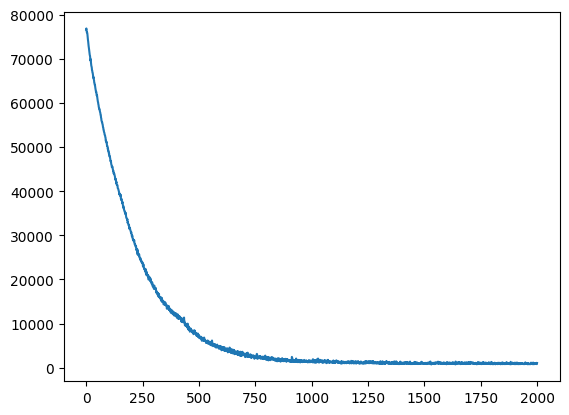

In [85]:
plt.plot(losses);

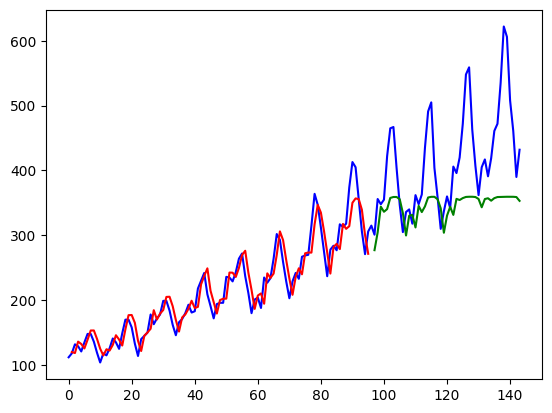

In [86]:
def plot_predicts():
  with torch.no_grad():
      # Shift in predictions for training data
      train_plot = np.ones_like(passengers) * np.nan
      y_pred = model(X_train)
      y_pred = y_pred[:, -1]
      train_plot[lookback:len(train)] = model(X_train)[:, -1]

      # Shift in predictions for test data
      test_plot = np.ones_like(passengers) * np.nan
      test_plot[len(train)+lookback:len(passengers)] = model(X_test)[:, -1]

  # Visualisation of results
  plt.plot(passengers, c='b')  # Real data
  plt.plot(train_plot, c='r')  # Predictions based on training data
  plt.plot(test_plot, c='g')   # Predictions on test data
  plt.show()

plot_predicts()

Let's train the model with hidden_size=100 and compare the results with the previous ones.

In [87]:
model = AirModel( hidden_size=200, num_layers=1)

In [88]:
losses = train_model(model)

Epoch 0: train RMSE 224.5480, test RMSE 421.3453
Epoch 100: train RMSE 77.5590, test RMSE 245.5449
Epoch 200: train RMSE 38.5287, test RMSE 174.1830
Epoch 300: train RMSE 28.1939, test RMSE 137.7684
Epoch 400: train RMSE 24.4262, test RMSE 112.0053
Epoch 500: train RMSE 23.0520, test RMSE 94.9711
Epoch 600: train RMSE 23.9671, test RMSE 86.7844
Epoch 700: train RMSE 23.7676, test RMSE 87.8659
Epoch 800: train RMSE 23.2324, test RMSE 81.0161
Epoch 900: train RMSE 23.0963, test RMSE 79.1943
Epoch 1000: train RMSE 23.1241, test RMSE 81.1462
Epoch 1100: train RMSE 22.6203, test RMSE 75.0385
Epoch 1200: train RMSE 22.8573, test RMSE 74.8422
Epoch 1300: train RMSE 22.6560, test RMSE 70.1118
Epoch 1400: train RMSE 22.7711, test RMSE 73.9737
Epoch 1500: train RMSE 22.5809, test RMSE 69.2659
Epoch 1600: train RMSE 23.6263, test RMSE 73.2784
Epoch 1700: train RMSE 22.8781, test RMSE 78.1586
Epoch 1800: train RMSE 22.2234, test RMSE 71.1096
Epoch 1900: train RMSE 22.4257, test RMSE 74.5662


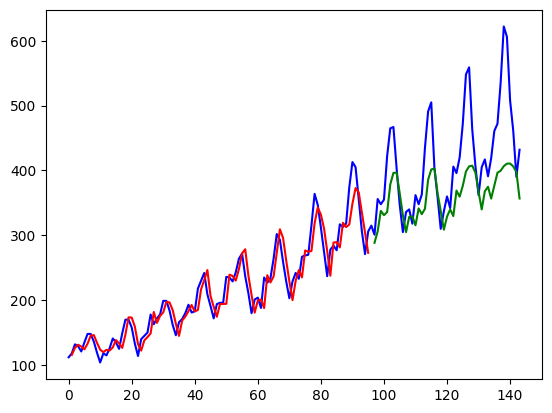

In [90]:
plot_predicts()

As you can see from the graph, the model's performance has improved
---

